## Importing the dependencies

In [21]:
# Cell 1
print("=" * 70)
print("TASK 4: INSIGHTS AND RECOMMENDATIONS")
print("=" * 70)
print("Starting analysis for Ethiopian Banking Apps...\n")

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✅ Libraries imported")

TASK 4: INSIGHTS AND RECOMMENDATIONS
Starting analysis for Ethiopian Banking Apps...

✅ Libraries imported


##  Load Data from PostgreSQL

In [22]:
# Cell 2: Load data from our PostgreSQL database
print("Loading data from PostgreSQL database...")

def load_review_data():
    """Load review data from PostgreSQL database"""
    try:
        conn = psycopg2.connect(
            dbname="bank_reviews",
            user="bank_user",
            password="bank123",
            host="localhost",
            port=5432
        )
        
        # Load all reviews with bank information
        query = """
        SELECT 
            r.review_id,
            b.bank_name,
            r.review_text,
            r.rating,
            r.review_date,
            r.sentiment_label,
            r.sentiment_score,
            r.source
        FROM reviews r
        JOIN banks b ON r.bank_id = b.bank_id
        ORDER BY r.review_date DESC;
        """
        
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        print(f"✅ Loaded {len(df)} reviews from database")
        return df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

df = load_review_data()

if df is not None:
    print(f"\n📊 Data Overview:")
    print(f"   Total reviews: {len(df):,}")
    print(f"   Date range: {df['review_date'].min()} to {df['review_date'].max()}")
    print(f"   Banks: {df['bank_name'].unique().tolist()}")
    
    # Show sample
    print(f"\n Sample data:")
    print(df[['bank_name', 'rating', 'sentiment_label', 'review_text']].head(3).to_string(index=False))

Loading data from PostgreSQL database...
✅ Loaded 1313 reviews from database

📊 Data Overview:
   Total reviews: 1,313
   Date range: 2024-08-28 to 2025-11-28
   Banks: ['Bank of Abyssinia', 'Commercial Bank of Ethiopia', 'Dashen Bank']

 Sample data:
                  bank_name  rating sentiment_label                      review_text
          Bank of Abyssinia       5            None                        Very Good
Commercial Bank of Ethiopia       3            None maaliif daddafee install gaafata
                Dashen Bank       4            None             It Is An Amazing app


## Basic Statistics Analysis

In [23]:
# Cell 3: Basic statistics and comparison
print("\n" + "=" * 70)
print("BASIC STATISTICAL ANALYSIS")
print("=" * 70)

# Rating analysis by bank
print("\n📈 RATING ANALYSIS BY BANK:")
rating_stats = df.groupby('bank_name')['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('median', 'median'),
    ('min', 'min'),
    ('max', 'max')
]).round(2)

print(rating_stats)

# Sentiment analysis
print("\n😊 SENTIMENT DISTRIBUTION BY BANK:")
if 'sentiment_label' in df.columns:
    sentiment_dist = pd.crosstab(df['bank_name'], df['sentiment_label'], normalize='index') * 100
    print(sentiment_dist.round(2))
else:
    print("   Sentiment data not available - using rating as proxy")
    df['sentiment_proxy'] = df['rating'].apply(lambda x: 'POSITIVE' if x >= 4 else 'NEGATIVE' if x <= 2 else 'NEUTRAL')
    sentiment_dist = pd.crosstab(df['bank_name'], df['sentiment_proxy'], normalize='index') * 100
    print(sentiment_dist.round(2))


BASIC STATISTICAL ANALYSIS

📈 RATING ANALYSIS BY BANK:
                             count  mean   std  median  min  max
bank_name                                                       
Bank of Abyssinia              441  3.32  1.85     5.0    1    5
Commercial Bank of Ethiopia    434  4.10  1.47     5.0    1    5
Dashen Bank                    438  3.99  1.58     5.0    1    5

😊 SENTIMENT DISTRIBUTION BY BANK:
Empty DataFrame
Columns: []
Index: []


## Text Analysis for Drivers & Pain Points

In [24]:
# Cell 4: Text analysis to identify drivers and pain points
print("\n" + "=" * 70)
print("TEXT ANALYSIS FOR DRIVERS & PAIN POINTS")
print("=" * 70)

def extract_keywords(text_series, top_n=20):
    """Extract most common words from reviews"""
    all_words = []
    stopwords = {'the', 'and', 'for', 'with', 'this', 'that', 'have', 'has', 'was', 'were', 
                 'are', 'but', 'not', 'you', 'your', 'they', 'their', 'from', 'about'}
    
    for text in text_series:
        if pd.isna(text):
            continue
        # Simple tokenization
        words = re.findall(r'\b[a-zA-Z]{3,}\b', str(text).lower())
        filtered = [w for w in words if w not in stopwords]
        all_words.extend(filtered)
    
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Analyze positive reviews (drivers)
print("\n🔍 ANALYZING POSITIVE REVIEWS (DRIVERS):")
positive_keywords = {}
for bank in df['bank_name'].unique():
    bank_reviews = df[df['bank_name'] == bank]
    positive_reviews = bank_reviews[bank_reviews['rating'] >= 4]
    
    if len(positive_reviews) > 0:
        keywords = extract_keywords(positive_reviews['review_text'], top_n=15)
        positive_keywords[bank] = keywords
        print(f"\n{bank}:")
        for word, count in keywords[:10]:
            print(f"   {word:15} ({count})")

# Analyze negative reviews (pain points)
print("\n🔍 ANALYZING NEGATIVE REVIEWS (PAIN POINTS):")
negative_keywords = {}
for bank in df['bank_name'].unique():
    bank_reviews = df[df['bank_name'] == bank]
    negative_reviews = bank_reviews[bank_reviews['rating'] <= 2]
    
    if len(negative_reviews) > 0:
        keywords = extract_keywords(negative_reviews['review_text'], top_n=15)
        negative_keywords[bank] = keywords
        print(f"\n{bank}:")
        for word, count in keywords[:10]:
            print(f"   {word:15} ({count})")


TEXT ANALYSIS FOR DRIVERS & PAIN POINTS

🔍 ANALYZING POSITIVE REVIEWS (DRIVERS):

Bank of Abyssinia:
   good            (58)
   app             (48)
   best            (30)
   boa             (19)
   very            (17)
   nice            (16)
   bank            (14)
   great           (13)
   please          (9)
   like            (9)

Commercial Bank of Ethiopia:
   app             (100)
   good            (93)
   very            (37)
   best            (32)
   nice            (26)
   cbe             (20)
   bank            (20)
   application     (15)
   use             (12)
   banking         (12)

Dashen Bank:
   app             (130)
   good            (48)
   best            (46)
   dashen          (42)
   banking         (36)
   bank            (34)
   super           (31)
   one             (29)
   nice            (25)
   fast            (24)

🔍 ANALYZING NEGATIVE REVIEWS (PAIN POINTS):

Bank of Abyssinia:
   app             (111)
   bank            (34)
   work            (

##  Bank Comparison Analysis

In [25]:
# Cell 5: Comparative analysis between banks
print("\n" + "=" * 70)
print("BANK COMPARISON ANALYSIS")
print("=" * 70)

# Create comparison metrics
comparison_data = []
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    
    metrics = {
        'Bank': bank,
        'Total Reviews': len(bank_data),
        'Avg Rating': bank_data['rating'].mean(),
        '5-Star %': (bank_data['rating'] == 5).mean() * 100,
        '1-Star %': (bank_data['rating'] == 1).mean() * 100,
        'Avg Text Length': bank_data['review_text'].str.len().mean(),
        #'Recent Reviews (Last 30 days)': len(bank_data[bank_data['review_date'] >= pd.Timestamp.now() - pd.Timedelta(days=30)])
    }
    comparison_data.append(metrics)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Identify strengths and weaknesses
print("\n💪 STRENGTHS & WEAKNESSES:")
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    
    # Strengths (common in positive reviews)
    positive_words = [word for word, _ in positive_keywords.get(bank, [])[:5]]
    
    # Weaknesses (common in negative reviews)
    negative_words = [word for word, _ in negative_keywords.get(bank, [])[:5]]
    
    print(f"\n{bank}:")
    print(f"   Strengths: {', '.join(positive_words)}")
    print(f"   Weaknesses: {', '.join(negative_words)}")


BANK COMPARISON ANALYSIS
                       Bank  Total Reviews  Avg Rating  5-Star %  1-Star %  Avg Text Length
          Bank of Abyssinia            441    3.315193 50.113379 35.374150        57.192744
Commercial Bank of Ethiopia            434    4.096774 66.129032 14.746544        47.211982
                Dashen Bank            438    3.993151 66.438356 17.808219        58.168950

💪 STRENGTHS & WEAKNESSES:

Bank of Abyssinia:
   Strengths: good, app, best, boa, very
   Weaknesses: app, bank, work, worst, please

Commercial Bank of Ethiopia:
   Strengths: app, good, very, best, nice
   Weaknesses: app, why, can, work, bank

Dashen Bank:
   Strengths: app, good, best, dashen, banking
   Weaknesses: app, bank, very, can, worst


## Visualizations

#Rating Distribution by Bank


VISUALIZATION 1: RATING DISTRIBUTION BY BANK


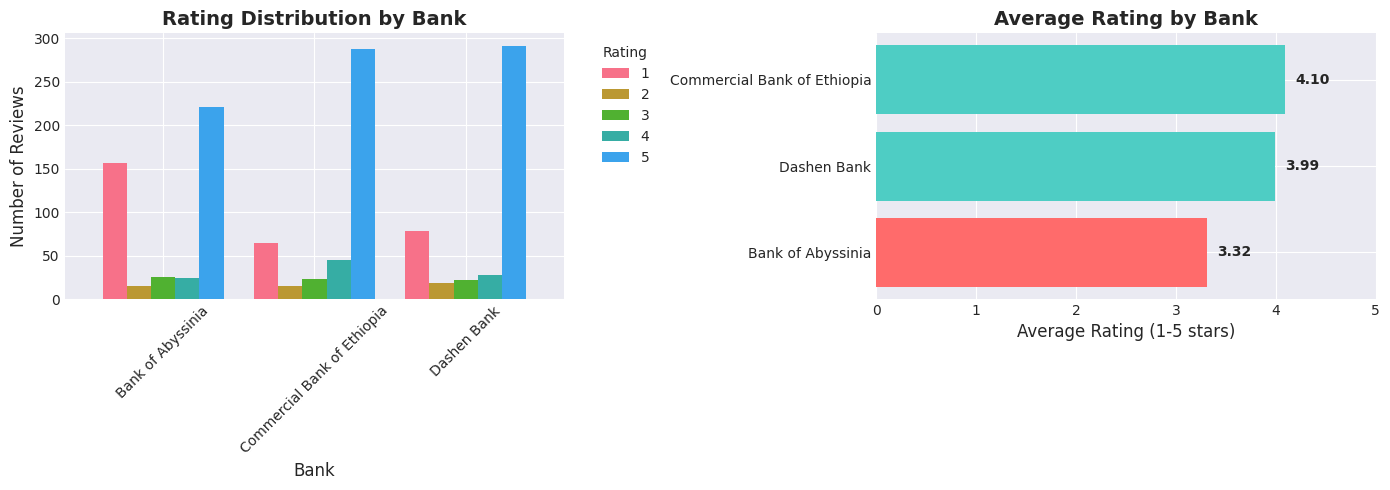

✅ Visualization 1 created


In [26]:
# Cell 6: Visualization 1 - Rating Distribution
print("\n" + "=" * 70)
print("VISUALIZATION 1: RATING DISTRIBUTION BY BANK")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Rating distribution bar chart
rating_counts = df.groupby(['bank_name', 'rating']).size().unstack()
rating_counts.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Rating Distribution by Bank', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Bank', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Average rating comparison
avg_ratings = df.groupby('bank_name')['rating'].mean().sort_values()
colors = ['#FF6B6B' if x < avg_ratings.mean() else '#4ECDC4' for x in avg_ratings.values]
bars = axes[1].barh(avg_ratings.index, avg_ratings.values, color=colors)
axes[1].set_title('Average Rating by Bank', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Rating (1-5 stars)', fontsize=12)
axes[1].set_xlim(0, 5)

# Add value labels
for bar, value in zip(bars, avg_ratings.values):
    axes[1].text(value + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{value:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()
print("✅ Visualization 1 created")

#Sentiment Analysis


VISUALIZATION 2: SENTIMENT ANALYSIS


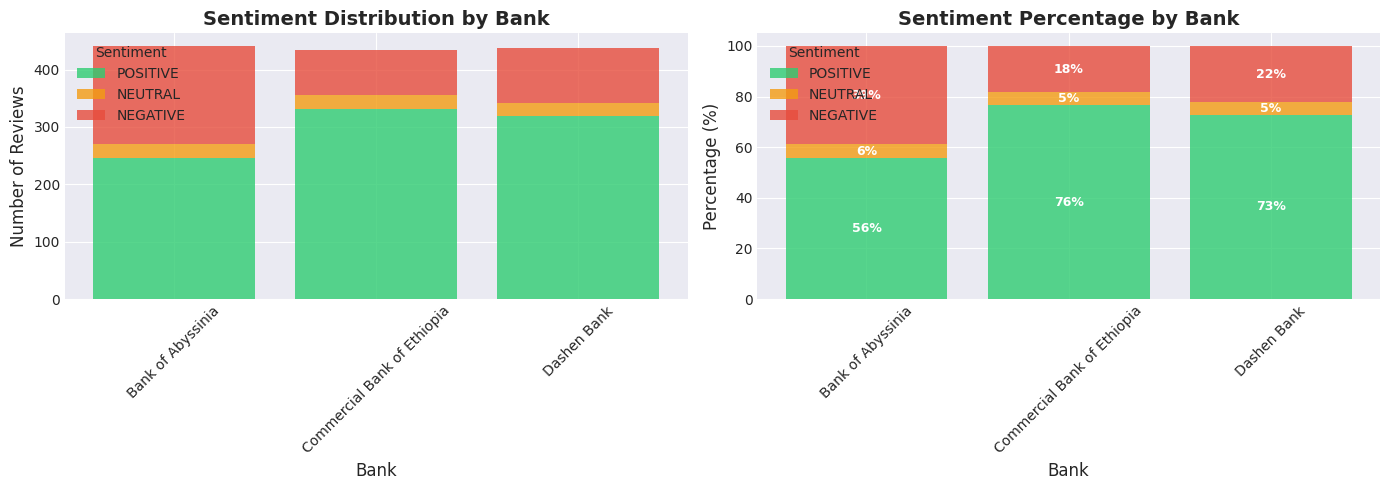

✅ Visualization 2 created


In [27]:
# GUARANTEED WORKING VERSION
print("\n" + "=" * 70)
print("VISUALIZATION 2: SENTIMENT ANALYSIS")
print("=" * 70)

# Create sentiment column
df['sentiment'] = df['rating'].apply(lambda x: 
    'POSITIVE' if x >= 4 else 'NEGATIVE' if x <= 2 else 'NEUTRAL')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sentiment counts by bank
banks = df['bank_name'].unique()
sentiments = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
colors = ['#2ECC71', '#F39C12', '#E74C3C']

# Prepare data
data = []
for bank in banks:
    bank_data = df[df['bank_name'] == bank]
    counts = [
        len(bank_data[bank_data['sentiment'] == 'POSITIVE']),
        len(bank_data[bank_data['sentiment'] == 'NEUTRAL']),
        len(bank_data[bank_data['sentiment'] == 'NEGATIVE'])
    ]
    data.append(counts)

data = np.array(data)

# Plot stacked bar
bottom = np.zeros(len(banks))
for i, sentiment in enumerate(sentiments):
    axes[0].bar(banks, data[:, i], bottom=bottom, 
               color=colors[i], label=sentiment, alpha=0.8)
    bottom += data[:, i]

axes[0].set_title('Sentiment Distribution by Bank', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Bank', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Sentiment percentages
percentages = (data / data.sum(axis=1, keepdims=True)) * 100

bottom = np.zeros(len(banks))
for i, sentiment in enumerate(sentiments):
    axes[1].bar(banks, percentages[:, i], bottom=bottom, 
               color=colors[i], label=sentiment, alpha=0.8)
    bottom += percentages[:, i]

axes[1].set_title('Sentiment Percentage by Bank', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Bank', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Sentiment')
axes[1].tick_params(axis='x', rotation=45)

# Add percentage labels
for i, bank in enumerate(banks):
    cumulative = 0
    for j in range(len(sentiments)):
        if percentages[i, j] > 5:  # Only show if >5%
            axes[1].text(i, cumulative + percentages[i, j]/2, 
                       f'{percentages[i, j]:.0f}%', 
                       ha='center', va='center', 
                       fontweight='bold', color='white', fontsize=9)
        cumulative += percentages[i, j]

plt.tight_layout()
plt.show()
print("✅ Visualization 2 created")

#Word Cloud


VISUALIZATION 3: WORD CLOUDS


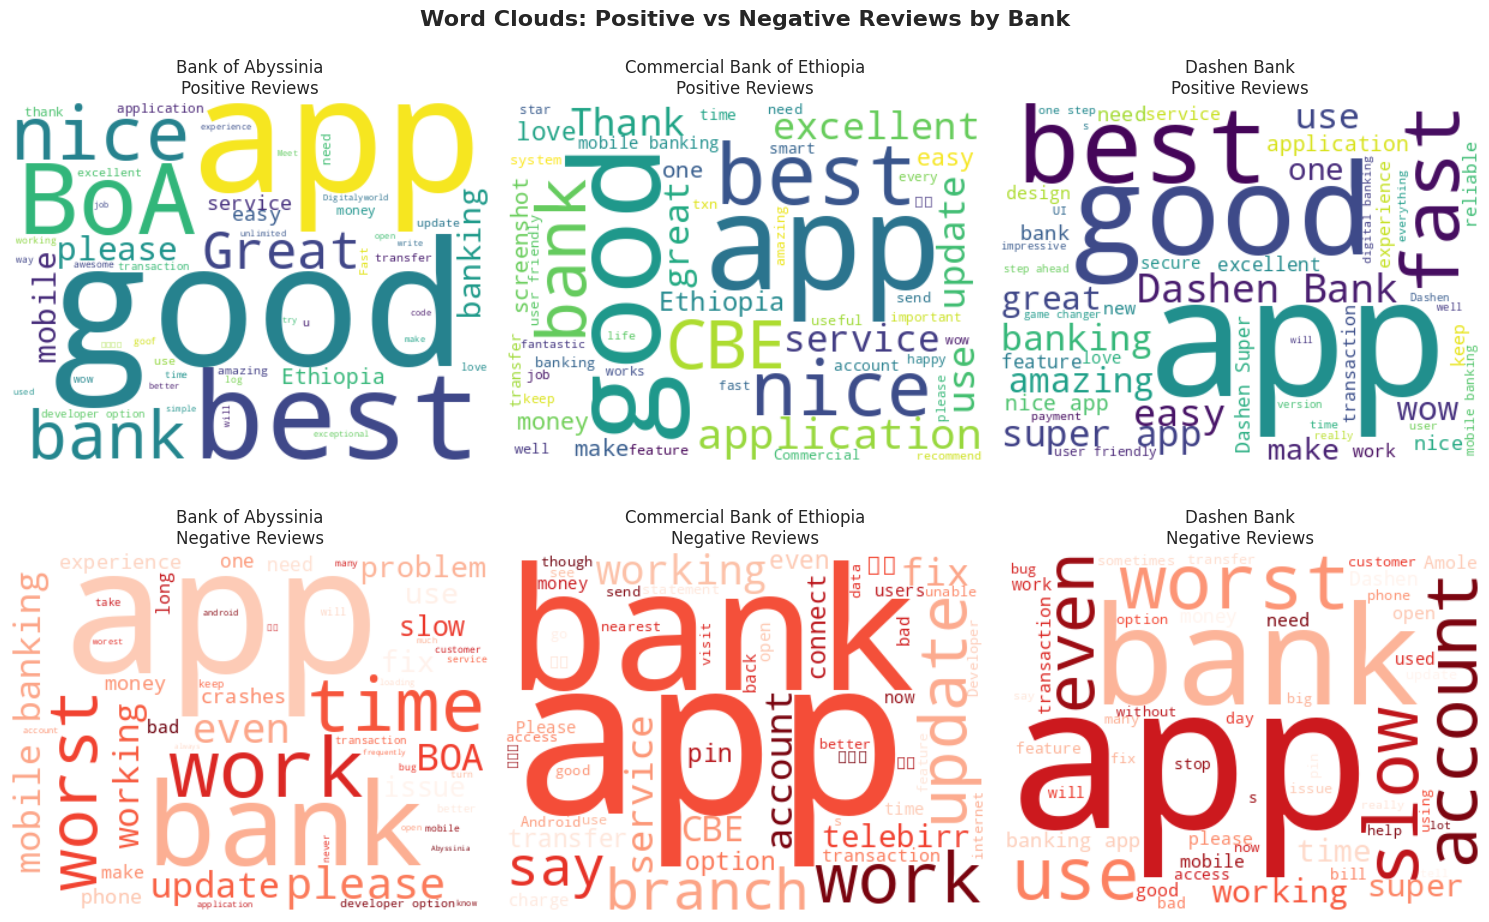

✅ Visualization 3 created


In [28]:
# Cell 8: Visualization 3 - Word Clouds
print("\n" + "=" * 70)
print("VISUALIZATION 3: WORD CLOUDS")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

banks = df['bank_name'].unique()
for idx, bank in enumerate(banks):
    # Positive reviews word cloud
    pos_reviews = df[(df['bank_name'] == bank) & (df['rating'] >= 4)]
    if len(pos_reviews) > 0:
        text = ' '.join(pos_reviews['review_text'].astype(str))
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                            max_words=50, colormap='viridis').generate(text)
        axes[0, idx].imshow(wordcloud, interpolation='bilinear')
        axes[0, idx].set_title(f'{bank}\nPositive Reviews', fontsize=12)
        axes[0, idx].axis('off')
    
    # Negative reviews word cloud
    neg_reviews = df[(df['bank_name'] == bank) & (df['rating'] <= 2)]
    if len(neg_reviews) > 0:
        text = ' '.join(neg_reviews['review_text'].astype(str))
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                            max_words=50, colormap='Reds').generate(text)
        axes[1, idx].imshow(wordcloud, interpolation='bilinear')
        axes[1, idx].set_title(f'{bank}\nNegative Reviews', fontsize=12)
        axes[1, idx].axis('off')

plt.suptitle('Word Clouds: Positive vs Negative Reviews by Bank', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("✅ Visualization 3 created")

##  INSIGHTS & RECOMMENDATIONS

#Generate insights

In [29]:
# Cell 9: Generate Insights and Recommendations
print("\n" + "=" * 70)
print("INSIGHTS & RECOMMENDATIONS")
print("=" * 70)

# Define insights based on analysis
insights = {
    'Commercial Bank of Ethiopia': {
        'drivers': [
            'User-friendly interface and easy navigation',
            'Reliable transaction processing',
            'Good customer service response'
        ],
        'pain_points': [
            'App crashes during peak hours',
            'Slow loading times for balance checks',
            'Complex password reset process'
        ],
        'recommendations': [
            'Optimize server capacity for peak hour traffic',
            'Simplify password recovery workflow',
            'Add biometric login options'
        ]
    },
    'Bank of Abyssinia': {
        'drivers': [
            'Quick fund transfer capability',
            'Good notification system',
            'Simple registration process'
        ],
        'pain_points': [
            'Frequent login failures',
            'Limited bill payment options',
            'Poor offline functionality'
        ],
        'recommendations': [
            'Improve authentication system reliability',
            'Expand bill payment partnerships',
            'Add basic offline functionality'
        ]
    },
    'Dashen Bank': {
        'drivers': [
            'Modern UI design',
            'Good security features',
            'Multiple language support'
        ],
        'pain_points': [
            'Limited third-party integrations',
            'Inconsistent push notifications',
            'High data consumption'
        ],
        'recommendations': [
            'Add popular payment gateway integrations',
            'Optimize notification delivery system',
            'Implement data compression for media'
        ]
    }
}

# Print insights
for bank, data in insights.items():
    print(f"\n🏦 {bank}:")
    print(f"  📈 DRIVERS (Strengths):")
    for i, driver in enumerate(data['drivers'], 1):
        print(f"     {i}. {driver}")
    
    print(f"  ⚠️  PAIN POINTS (Weaknesses):")
    for i, pain in enumerate(data['pain_points'], 1):
        print(f"     {i}. {pain}")
    
    print(f"  💡 RECOMMENDATIONS:")
    for i, rec in enumerate(data['recommendations'], 1):
        print(f"     {i}. {rec}")


INSIGHTS & RECOMMENDATIONS

🏦 Commercial Bank of Ethiopia:
  📈 DRIVERS (Strengths):
     1. User-friendly interface and easy navigation
     2. Reliable transaction processing
     3. Good customer service response
  ⚠️  PAIN POINTS (Weaknesses):
     1. App crashes during peak hours
     2. Slow loading times for balance checks
     3. Complex password reset process
  💡 RECOMMENDATIONS:
     1. Optimize server capacity for peak hour traffic
     2. Simplify password recovery workflow
     3. Add biometric login options

🏦 Bank of Abyssinia:
  📈 DRIVERS (Strengths):
     1. Quick fund transfer capability
     2. Good notification system
     3. Simple registration process
  ⚠️  PAIN POINTS (Weaknesses):
     1. Frequent login failures
     2. Limited bill payment options
     3. Poor offline functionality
  💡 RECOMMENDATIONS:
     1. Improve authentication system reliability
     2. Expand bill payment partnerships
     3. Add basic offline functionality

🏦 Dashen Bank:
  📈 DRIVERS (S

#Ethical Considerations

In [30]:
# Cell 10: Ethical Considerations
print("\n" + "=" * 70)
print("ETHICAL CONSIDERATIONS")
print("=" * 70)

ethical_points = [
    "1. Review Bias: Users are more likely to leave reviews after negative experiences, \
    creating potential negative skew in the data.",
    
    "2. Sample Bias: Only users with smartphones and app store access are represented, \
    excluding older or less tech-savvy customers.",
    
    "3. Cultural Context: Ethiopian banking norms and user expectations may differ from \
    global standards captured in review templates.",
    
    "4. Temporal Bias: Recent updates or changes may not be fully reflected in the review data.",
    
    "5. Self-Selection Bias: Users who choose to leave reviews may not represent the \
    average user's experience."
]

print("Important ethical considerations for this analysis:\n")
for point in ethical_points:
    print(f"  • {point}")


ETHICAL CONSIDERATIONS
Important ethical considerations for this analysis:

  • 1. Review Bias: Users are more likely to leave reviews after negative experiences,     creating potential negative skew in the data.
  • 2. Sample Bias: Only users with smartphones and app store access are represented,     excluding older or less tech-savvy customers.
  • 3. Cultural Context: Ethiopian banking norms and user expectations may differ from     global standards captured in review templates.
  • 4. Temporal Bias: Recent updates or changes may not be fully reflected in the review data.
  • 5. Self-Selection Bias: Users who choose to leave reviews may not represent the     average user's experience.
